# Test rsfc matrix extraction

Use the default harvard oxford atlas and the power spheres we've defined to ensure fc matrices look about right

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
%matplotlib inline

%run -i example_sub.py

#grab the harvard oxford labels 
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

#create a masker that will allow us to extract signal from rois defined here
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=0)
#initiallize a clean variable to hold the extracted timeseries
time_series = None
if os.path.isfile(rsfilename):
    anImg = nib.load(rsfilename)
    time_series = masker.fit_transform(anImg)

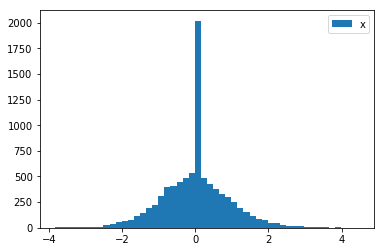

In [2]:
#plot a histogram to check
plt.pyplot.hist(time_series.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

In [3]:
#compute the connectivity matrix
#This uses a slightly regularized correlation estimator
#https://neurostars.org/t/connectivitymeasure-function-in-nilearn-compare-with-corrcoef-in-matlab/3659/2
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, None)

#again, check the hist


/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


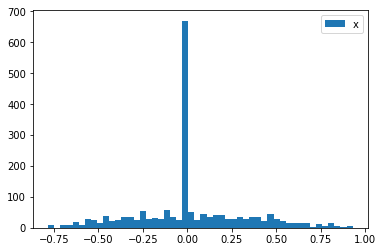

In [4]:
plt.pyplot.hist(correlation_matrix.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()


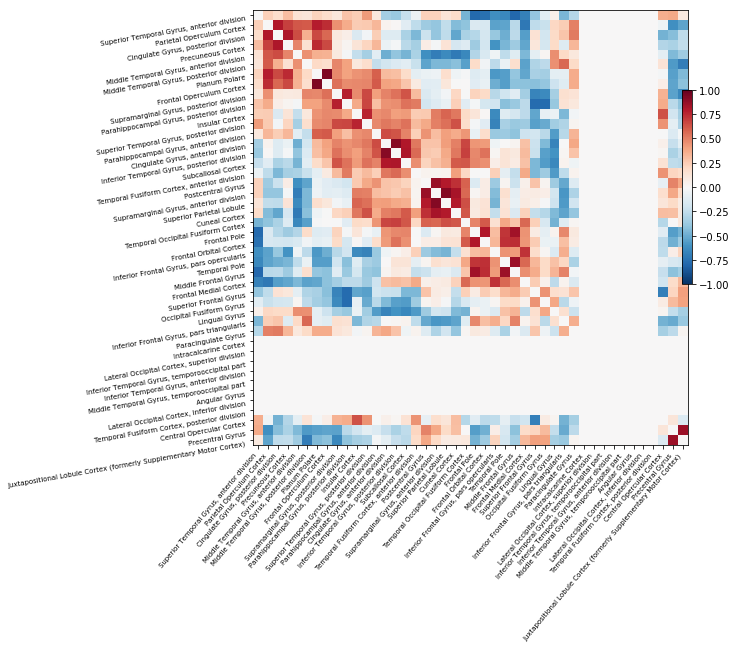

In [5]:
# Plot the correlation matrix
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=1, vmin=-1, reorder=True)

# Repeat, but with the parcellation scheme we're using

In [6]:
rsfilename = '/data/mounts/scs-fs-20/kpsy/genr/users/jflournoy/GenR_motion/sub-1355/ses-F09/func/sub-1355_ses-F09_task-rest_acq-0006_run-0000_space-T1w_desc-36P_nuisanced_bold.nii.gz'
masker2 = NiftiLabelsMasker(labels_img='/data/mounts/scs-fs-20/kpsy/genr/mrdata/GenR_MRI/bids/derivatives/fmriprep/sub-1355/anat/sub-1355-power_drysdale_warped.nii', standardize=True,
                            memory='nilearn_cache', verbose=0)
correlation_measure = ConnectivityMeasure(kind='correlation')
time_series2 = None
if os.path.isfile(rsfilename):
    anImg = nib.load(rsfilename)
    time_series2 = masker2.fit_transform(anImg)
correlation_matrix2 = correlation_measure.fit_transform([time_series2])[0]

#get our labels -- these are just network labels
power_drysdale_df = pd.read_csv('../power_spheres/power_drysdale_labels.csv', sep=',')
power_drysdale_labels = list(power_drysdale_df['label'].values)

In [24]:
time_series2.shape

(195, 278)

In [13]:
pd.DataFrame(data=masker2.labels_, columns = ['roi'])

,roi
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0
5,6.0
6,7.0
7,8.0
8,9.0
9,10.0


In [81]:
labels = power_drysdale_df['label'].values
roi_numbers = power_drysdale_df['roi'].values

labels_extracted=labels[np.isin(roi_numbers, np.asarray(masker2.labels_))]
masker_labels = np.asarray(masker2.labels_)
(correlation_matrix2.shape[0] == labels_extracted.shape[0] & time_series2.shape[1] == labels_extracted.shape[0])
np.arange(999, 999+time_series2.shape[1], 1).shape

(278,)

In [82]:
f=0
t=time_series2
c=correlation_matrix2
sid='sub-1355'
outpath='/data/mounts/scs-fs-20/kpsy/genr/users/jflournoy/rsfc_derivatives/'

In [95]:
#from script
sid = str(sid)
sid_outpath = os.path.join(outpath, sid)
if not os.path.isdir(sid_outpath):
    try:
        os.makedirs(sid_outpath)
    except:
        print("Cannot make dir {}".format(sid_outpath))
        raise
outfilename = sid
outfilename_cr = os.path.join(sid_outpath, outfilename + '_corrmat.csv')
outfilename_ts = os.path.join(sid_outpath, outfilename + '_timeseries.csv')

uppertri_indexes = np.triu_indices_from(c, k=1)
uppertri_data = c[uppertri_indexes]

cor_row_rois = masker_labels[uppertri_indexes[0]].astype(int)
cor_col_rois = masker_labels[uppertri_indexes[1]].astype(int)
c_df = pd.DataFrame({'r': uppertri_data, 'row': cor_row_rois, 'col': cor_col_rois})
t_df = pd.DataFrame(t, columns=labels_extracted).assign(tr = list(range(1,t.shape[0]+1))).melt(id_vars='tr', var_name='label')

c_df.to_csv(outfilename_cr)
t_df.to_csv(outfilename_ts)

In [108]:
np.array(['a', 'b'])

array(['a', 'b'], dtype='<U1')

In [100]:
masker_labels[uppertri_indexes[0]].astype(int)

array([  1,   1,   1, ..., 280, 280, 281])

In [10]:
power_drysdale_df

,Unnamed: 0,roi,network_name,label,X,Y,Z
0,0,1,Uncertain,1_Uncertain,-25,-98,-12
1,1,2,Uncertain,2_Uncertain,27,-97,-13
2,2,3,Uncertain,3_Uncertain,24,32,-18
3,3,4,Uncertain,4_Uncertain,-56,-45,-24
4,4,5,Uncertain,5_Uncertain,8,41,-24
5,5,6,Uncertain,6_Uncertain,-21,-22,-20
6,6,7,Uncertain,7_Uncertain,17,-28,-17
7,7,8,Uncertain,8_Uncertain,-37,-29,-26
8,8,9,Uncertain,9_Uncertain,65,-24,-19
9,9,10,Uncertain,10_Uncertain,52,-34,-27


In [16]:
anImg.slicer[:,:,:,0].shape

(42, 51, 36)

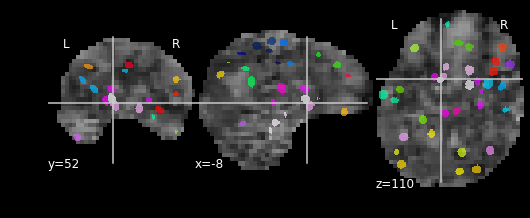

In [17]:
plotting.plot_roi('/data/mounts/scs-fs-20/kpsy/genr/mrdata/GenR_MRI/bids/derivatives/fmriprep/sub-1355/anat/sub-1355-power_drysdale_warped.nii',
                 bg_img=anImg.slicer[:,:,:,0])

/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jflournoy/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


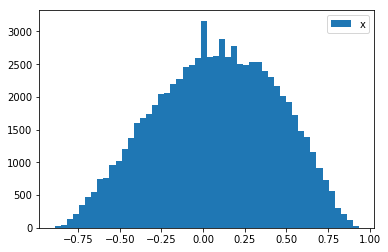

In [18]:
np.fill_diagonal(correlation_matrix2, None)
plt.pyplot.hist(correlation_matrix2.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

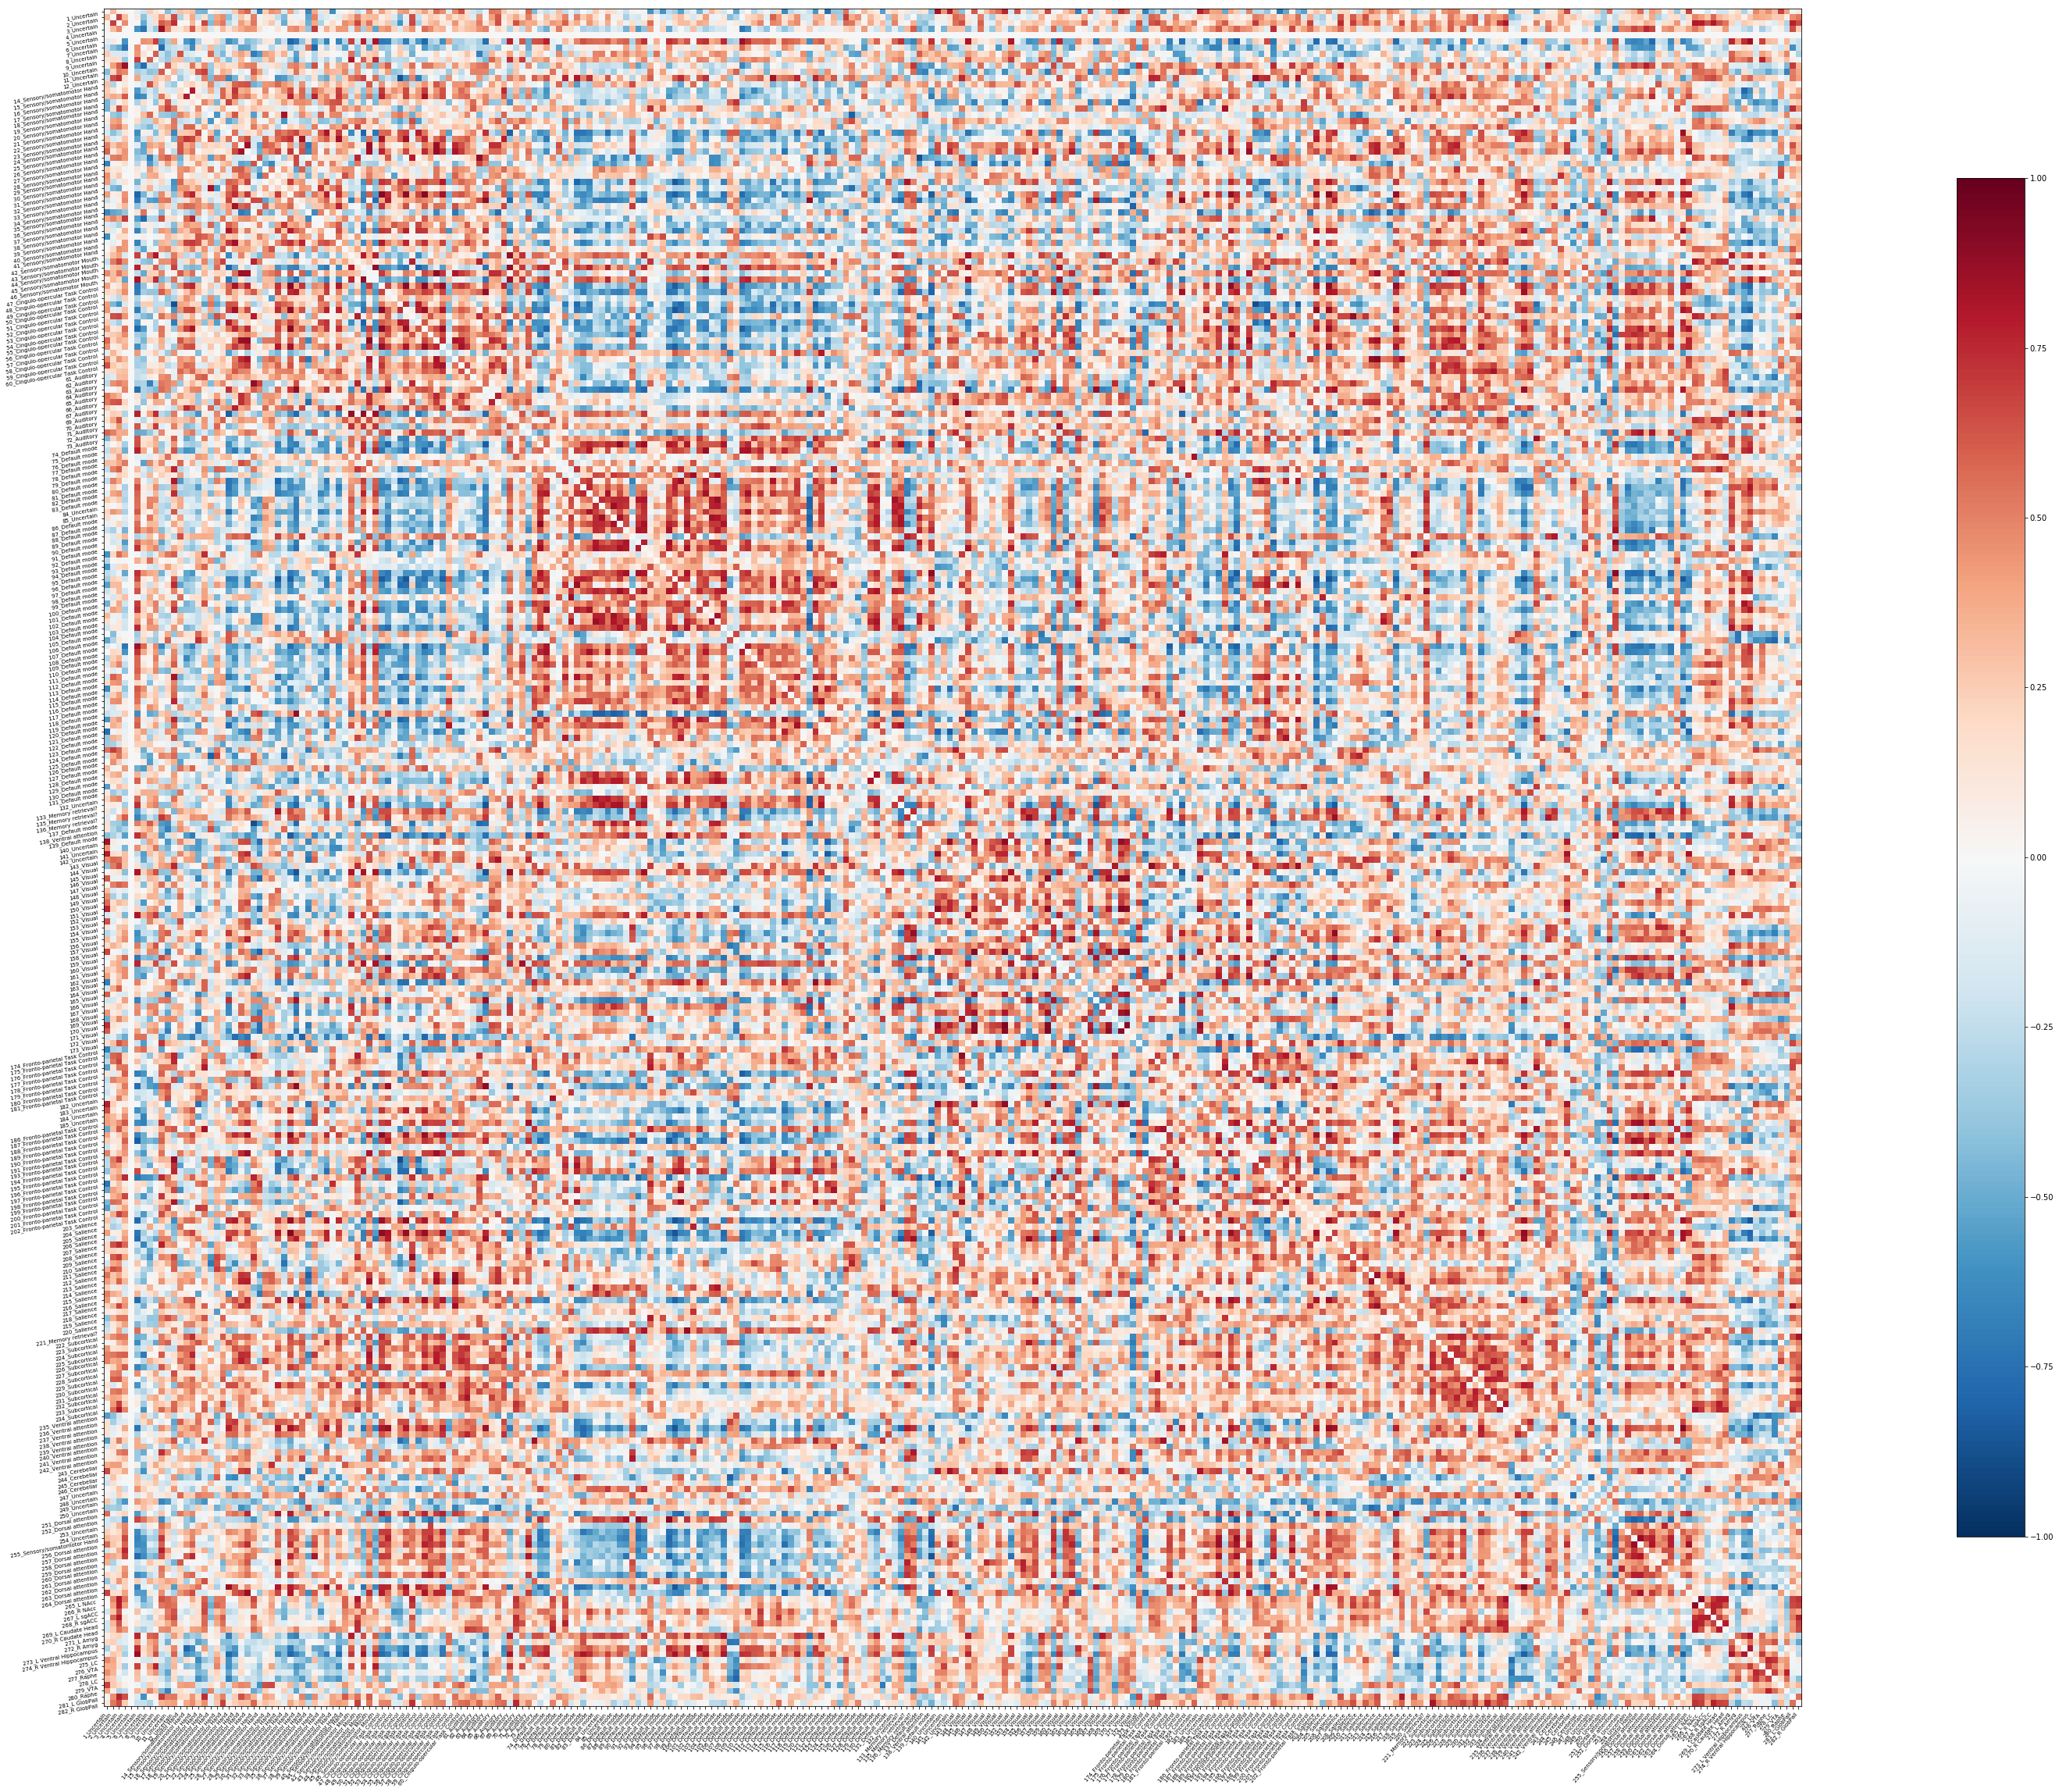

In [107]:
%matplotlib inline
np.fill_diagonal(correlation_matrix2, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix2, figure=(45, 40), labels=labels_extracted,
                     vmax=1, vmin=-1, reorder=False)

In [22]:
correlation_matrix2

(278, 278)

ValueError: Shape mismatch between 'adjacency_matrix' and 'node_coords''adjacency_matrix' shape is (278, 278), 'node_coords' shape is (282, 3)

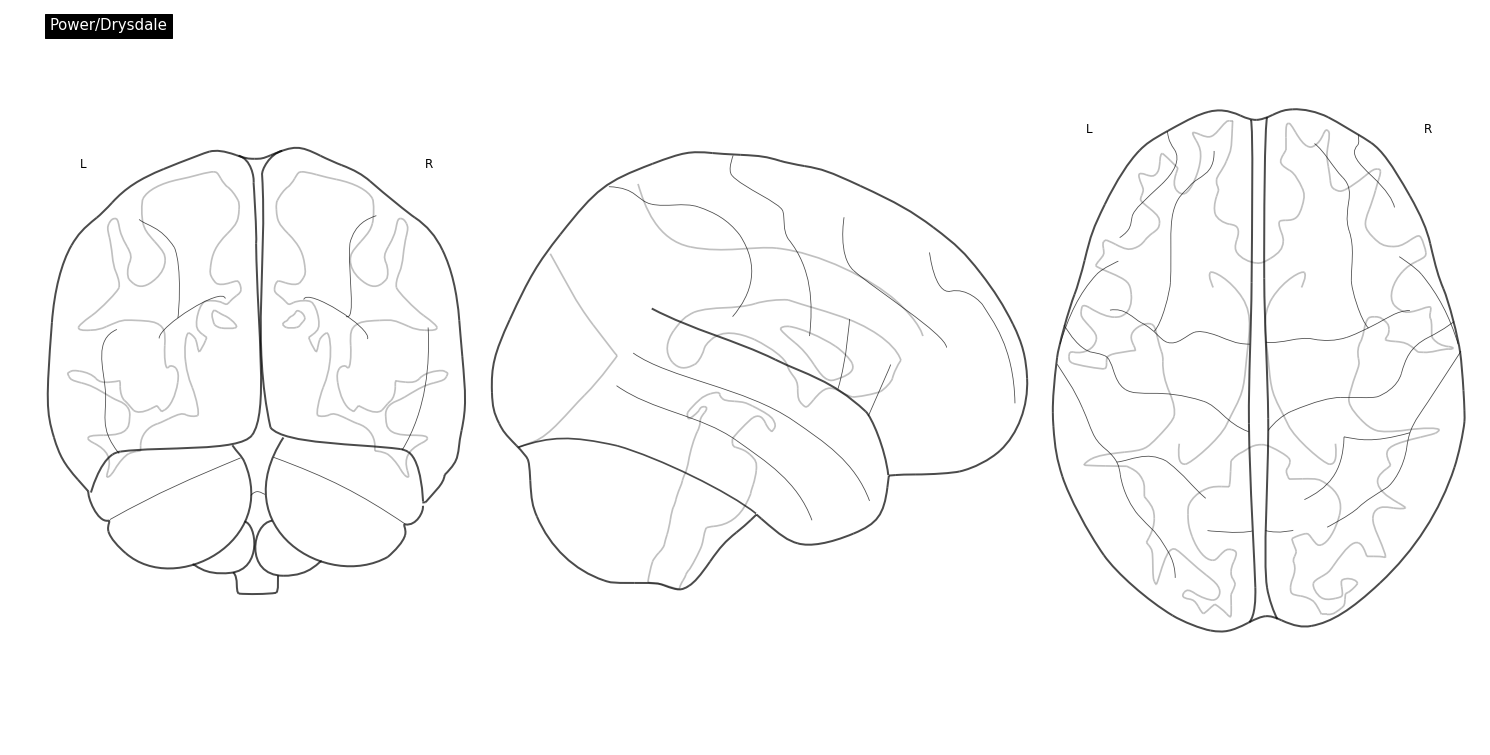

In [20]:
coordinates_power = power_drysdale_df[['X', 'Y', 'Z']].values

fig = plt.pyplot.figure(figsize=(20,10))
plotting.plot_connectome(correlation_matrix2, coordinates_power,
                         figure=fig,
                         edge_threshold="99.5%",
                         node_size=50,
                         title='Power/Drysdale')


# Test Yeo labels

In [ ]:
from nilearn.regions import connected_label_regions
yeo = datasets.fetch_atlas_yeo_2011()

In [ ]:
yeo_parcels = connected_label_regions(yeo.thick_17, connect_diag=False, min_size=None)

In [ ]:
voxel_mm3 = 4*(3.594**2)
unique, counts = np.unique(yeo_parcels.get_data(), return_counts=True)
big_parcel = unique[1:][counts[1:] == max(counts[1:])]
print("Biggest parcel: {}\nSize of voxel in mm: {}".format(big_parcel[0], voxel_mm3))
plt.pyplot.hist(counts[1:], bins=50)
plt.pyplot.show()

In [ ]:
yeo_biggest_parcel = yeo_parcels
yeo_biggest_parcel.dataobj[yeo_biggest_parcel.dataobj != big_parcel] = 0
plotting.plot_roi(yeo_biggest_parcel)

In [ ]:
yeo_parcels_gt100 = connected_label_regions(yeo.thick_17, connect_diag=False, min_size=voxel_mm3*2)

In [ ]:
plotting.plot_roi(yeo_parcels_gt100, cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

In [ ]:
yeo_parcel_coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo_parcels_gt100)


In [ ]:
import pickle
pickle_yeo_out = open("yeo_parcels_gt100.pickle","wb")
pickle.dump({"parcels": yeo_parcels_gt100, 
             "coords": yeo_parcel_coordinates}, 
            pickle_yeo_out)
pickle_yeo_out.close()

In [ ]:
# extract time series from all subjects and concatenate them
masker3 = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,
                            memory='nilearn_cache')
time_series3 = []
# for func, confounds in zip(data.func, data.confounds):
#     time_series.append(masker.fit_transform(func, confounds=confounds))
time_series3 = masker3.fit_transform(anImg)
correlation_matrix3 = correlation_measure.fit_transform([time_series3])[0]
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

In [ ]:
np.fill_diagonal(correlation_matrix3, None)
plt.pyplot.hist(correlation_matrix3.flatten(), bins=50, alpha=1, label='x')
plt.pyplot.legend(loc='upper right')
plt.pyplot.show()

In [ ]:
coordinates

In [ ]:
yeo_labels = list()
for coords in coordinates:
    yeo_labels.append("_".join("{0}".format(np.round(n,0)) for n in coords))
yeo_labels

In [ ]:
np.fill_diagonal(correlation_matrix3, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix3, figure=(10, 8), labels=yeo_labels,
                     vmax=1, vmin=-1, reorder=True)

In [ ]:
plotting.plot_connectome(correlation_matrix3, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')